In [5]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]


# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


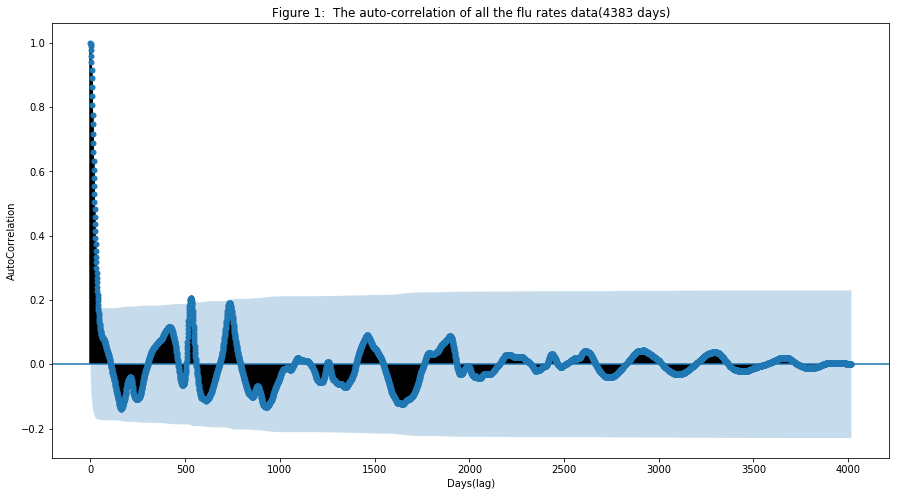

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train1_y2.values)

plt.title("Figure 1:  The auto-correlation of all the flu rates data(4383 days)")
plt.ylabel('AutoCorrelation')
plt.xlabel('Days(lag)')
plt.show()

In [5]:
from statsmodels.graphics.tsaplots import acf
acf(train1_y2.values,nlags=733)[90:110]


array([ 0.03785795,  0.03612917,  0.03443465,  0.0327451 ,  0.03103061,
        0.02926188,  0.02740961,  0.02544452,  0.02333597,  0.02105467,
        0.01861955,  0.01604425,  0.01334761,  0.0105485 ,  0.00766576,
        0.00471725,  0.00172184, -0.00129773, -0.00431453, -0.00730574])

In [6]:
from statsmodels.graphics.tsaplots import acf
acf(train1_y2.values,nlags=733)[526:540]


array([0.20013702, 0.20291493, 0.20475808, 0.20566817, 0.2056469 ,
       0.20469596, 0.20282047, 0.20002215, 0.19631901, 0.19172695,
       0.18626395, 0.179948  , 0.1727971 , 0.16483005])

In [7]:
from statsmodels.graphics.tsaplots import acf
acf(train1_y2.values,nlags=800)[724:748]


array([0.16874642, 0.17308431, 0.17708945, 0.18068853, 0.18381125,
       0.18638431, 0.18841097, 0.18989167, 0.19082962, 0.191228  ,
       0.19109003, 0.19041685, 0.18921163, 0.18753794, 0.18546121,
       0.18304501, 0.18035292, 0.1774485 , 0.17439714, 0.17126241,
       0.16802503, 0.16466678, 0.16116839, 0.1575106 ])

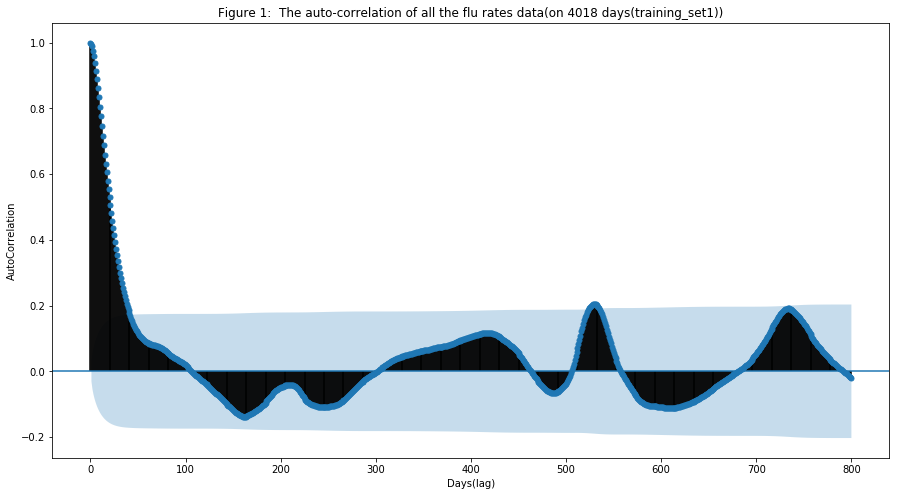

In [11]:
fig = sm.graphics.tsa.plot_acf(train1_y2.values, lags=800)
plt.title("Figure 1:  The auto-correlation of all the flu rates data(on 4018 days(training_set1))")
plt.ylabel('AutoCorrelation')
plt.xlabel('Days(lag)')
plt.show()

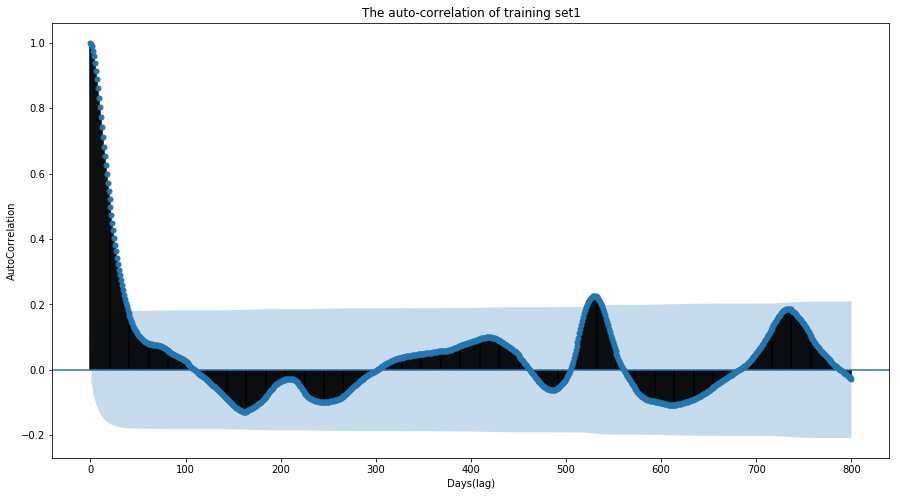

In [14]:
fig = sm.graphics.tsa.plot_acf(train2_y2.values, lags=800)
plt.title("The auto-correlation of training set1")
plt.ylabel('AutoCorrelation')
plt.xlabel('Days(lag)')
plt.savefig("Autocorrelation.pdf", bbox_inches='tight')

plt.show()

In [10]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]        
    if np.abs(r) > 0.19:
      print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else: 
      print('Appears to be not autocorrelated')
    return r, lag

In [11]:
y.values[:,0].shape

(4383,)

In [14]:
autocorr(train1_y2.values[:,0])

Appears to be autocorrelated with r = 0.9972340212560414, lag = 1


(0.9972340212560414, 1)

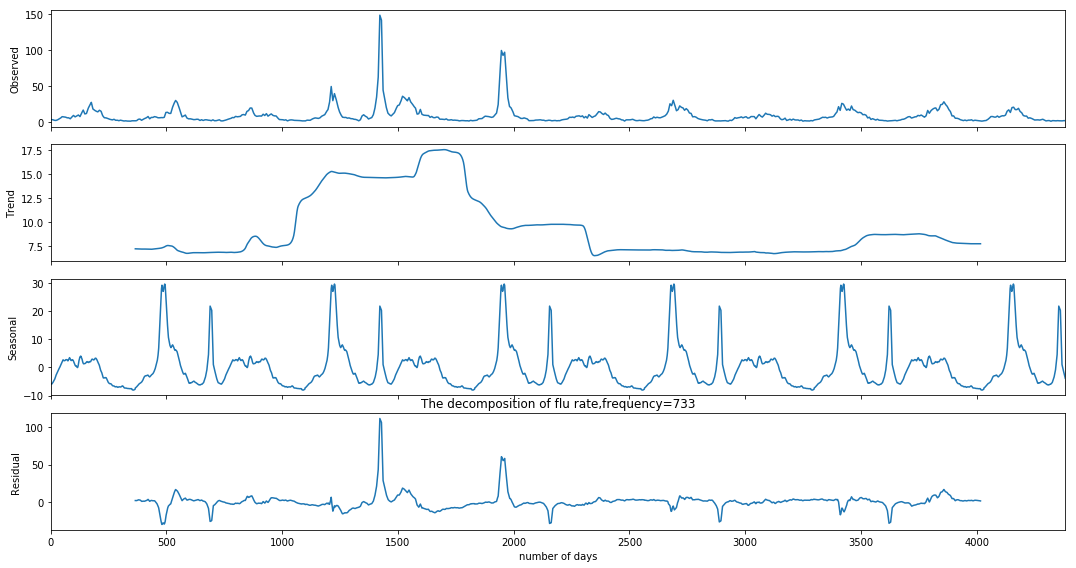

In [10]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [x for x in y.values]

result = seasonal_decompose(series, model='additive', freq=733)
result.plot()
plt.title("The decomposition of flu rate,frequency=733")
plt.xlabel('number of days')

plt.savefig("decomp_733.pdf", bbox_inches='tight')
plt.show()

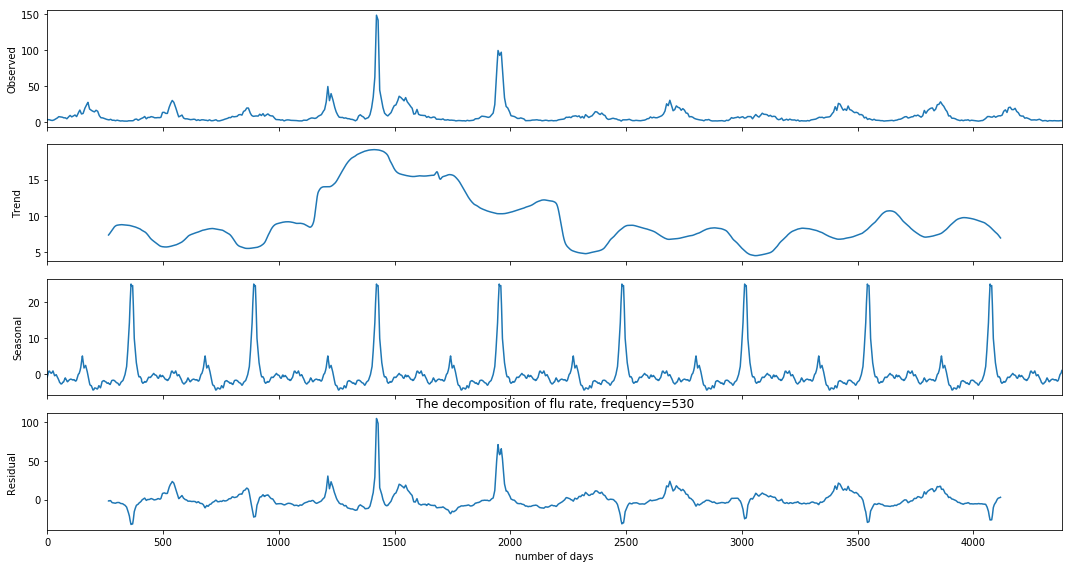

In [11]:
series = [x for x in y.values]

result = seasonal_decompose(series, model='additive', freq=530)
result.plot()
plt.title("The decomposition of flu rate, frequency=530")
plt.xlabel('number of days')
plt.savefig("decomp_530.pdf", bbox_inches='tight')
plt.show()

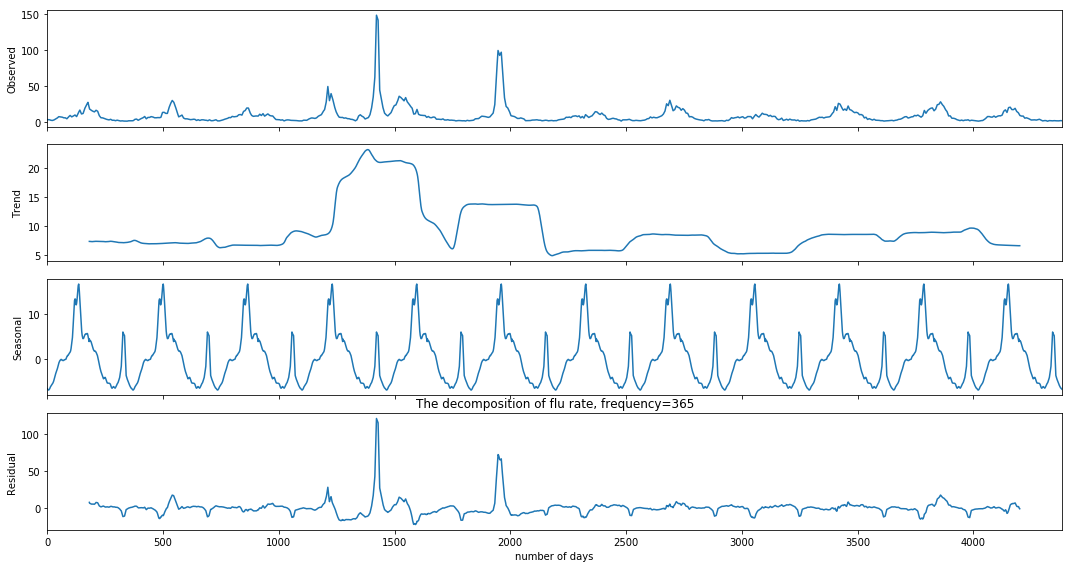

In [12]:
series = [x for x in y.values]

result = seasonal_decompose(series, model='additive', freq=365)
result.plot()
plt.title("The decomposition of flu rate, frequency=365")
plt.xlabel('number of days')
plt.savefig("decomp_365.pdf", bbox_inches='tight')
plt.show()